# KNN:

refs: 
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
* https://towardsdatascience.com/easily-visualize-scikit-learn-models-decision-boundaries-dd0fb3747508
* The Element of Statistical learning - From Least Square to Nearest Neighbors page 16


The K Nearest Neighborhood is one of the simple machine learning supervised classifiers. In the training phase, the algorithm just needs to "remember" the training data. The prediction is computed by returning the most frequent label of the kth nearest neighbor of the predicted point.
    
* Pros

    * Train is very fast. Just store the data
    * Easy to explain and simple to implement
    * k-NN performs much better if all of the data have the same scale
    * k-NN makes no assumptions about the functional form of the problem being solved
    * Can be used for imputing **missing values** of both categorical and continuous variables (**use the centroid of the class**)
    
* Crons 
    * Prediction is slow for mid-size to big data
    * Not good for high dimensional data. The eucledian distance does not work well under this situation. See: [The curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)


Some notes:

* In modern implementations it i spossible to choose the distance metrics:

    * Categorical data: Hamming Distance
    * Numerical data:
        * Eucledian distance (**Implementation in this notebook**)
        * Mahatan distance 


* The imapct of choosing k

```text
| RMSE  | k = 1       | increase k |
|-------+-------------+------------|
| Train | overffiting | increase   |
| test  | big         | decrease   |
|-------+-------------+------------|
```


In [1]:
import numpy as np
import pandas as pd
import random as rand
import  matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.datasets import make_classification, make_blobs
from sklearn.neighbors import KNeighborsClassifier

from typing import List, Set, Dict, Tuple, Optional, Union

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## Simulated data

Generating trainning data

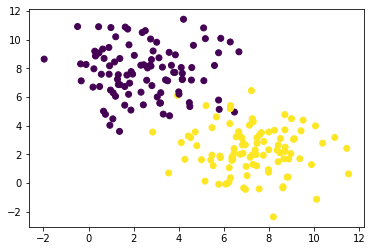

In [2]:
centers = [(2.5,7.5),(7.5,2.5)]
X_train, y_train = make_blobs(n_samples=200, centers=centers,cluster_std=1.75, n_features=2, random_state=0)

fig = plt.figure();
plt.scatter(X_train[:,0], X_train[:,1],c=y_train);

Generating test data

,X0,X1,y,label
0,6.472071,4.954860,0,Class1
1,7.980404,0.940899,1,Class2
2,2.616405,8.029326,0,Class1
3,0.355488,8.977635,0,Class1
4,1.094033,6.293288,0,Class1


<AxesSubplot:xlabel='X0', ylabel='X1'>

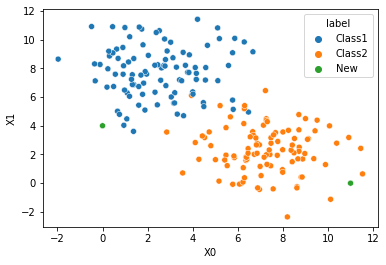

In [3]:
# centers = [(6.0,6.0)]
# X_test, y_test =  make_blobs(n_samples=5, centers=centers,cluster_std=1.0, n_features=2, random_state=0)
# y_label_test = np.ones(y_test.shape)*2
# y_label_test.astype(int)

X_test = np.array([[0.0,4.0],[11.0,0.0]])
y_test = [2,2]

X =  np.vstack((X_train,X_test))
y =  np.hstack((y_train,y_test)).astype(int)

# XXX: This plot is a way simler in ggplot
# for better pallete in seaborn ploter
number_to_label = {0: 'Class1', 1: 'Class2', 2: 'New'}
y_as_label = [number_to_label[k] for k in y]

data = pd.DataFrame({'X0': X[:,0], 'X1': X[:,1],'y': y, 'label': y_as_label})

data.head()
sns.scatterplot(data=data, x="X0", y="X1", hue="label");
plt.show()

In [4]:
# Brute force implementation
class KNN():

    def __init__(self, k):

        self.k = k
        self.X_train = None
        self.y_train = None
        
    def _eucledian_distance(self,a,b):
        
        return np.sqrt(np.sum((a - b)**2, axis=0))
        
    def fit(self, X: np.array, y: np.array):
        
        self.X_train = X.copy()
        self.y_train = y.copy()

    def predict(self,X_test: np.array) -> List[int]:
                 
        y_hat = []
        for x_test in X_test:
        
            distances = []
            for idx, x_train in enumerate(self.X_train):
                
                d = self._eucledian_distance(x_test,x_train)
                
                distances.append((idx, self.y_train[idx], d))
            
            # O(n log n)
            ranked_distances = sorted(distances, key=lambda t:t[2], reverse=False)[0:self.k]
            
            ranked_labels = [l for _, l, _ in ranked_distances]
            y_hat.append(max(Counter(ranked_labels)))
            
        return y_hat, ranked_distances  # <= for debug

tetsing Eucledian distance

In [5]:
a = np.array([0.0,0.0])
b = np.array([1.0,0.0])

knn = KNN(7)
knn._eucledian_distance(a,b)

b = np.array([4.0,3.0])
knn._eucledian_distance(a,b)


1.0

5.0

In [6]:
## test prediction
knn.fit(X_train, y_train)

# Expect y_hat = [1, 0, ?]. See plots above to understand expected values 
y_hat, ranked_distances = knn.predict(np.array([[0.0,10.0],[8.0,0.0],[8.0,7.0]]))

y_hat

[0, 1, 1]

In [11]:
X_train.shape

y_hat, ranked_distances = knn.predict(X_train[0:3,:])


print("Expected")
X_train[0:3,:]
y_train[0:3]

print("Predict")
# 2 correct and one mistake taht is fine. Just look the feature space graph to understand why?
y_hat  

(200, 2)

Expected


array([[6.47207059, 4.95486007],
       [7.98040363, 0.9408986 ],
       [2.61640514, 8.02932582]])

array([0, 1, 0])

Predict


[1, 1, 0]

## Prediction

Prediction for test data


array([[ 0.,  4.],
       [11.,  0.]])

[0, 1]

Ploting feaures spaces with test data


,X0,X1,label
0,6.472071,4.954860,Class1
1,7.980404,0.940899,Class2
2,2.616405,8.029326,Class1
3,0.355488,8.977635,Class1
4,1.094033,6.293288,Class1


<AxesSubplot:xlabel='X0', ylabel='X1'>

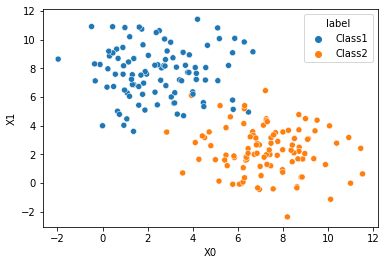

In [14]:
knn = KNN(7)
knn.fit(X_train, y_train)

y_hat, ranked_distances = knn.predict(X_test)

print("Prediction for test data")
X_test
y_hat  # Expected [0,1]

print("Ploting feaures spaces with test data")
Xl = X
yl =  np.hstack((y_train,y_hat))

y_as_label = [number_to_label[k] for k in yl]

data = pd.DataFrame({'X0': Xl[:,0], 'X1': Xl[:,1],'label': y_as_label})

data.head()
sns.scatterplot(data=data, x="X0", y="X1", hue="label");
plt.show()


* Comparing with scikitlearn implementation

In [15]:
knn_sci = KNeighborsClassifier(n_neighbors=7)
knn_sci.fit(X_train, y_train)

y_hat_ref = knn_sci.predict(X_test)

X_test
y_hat
y_hat_ref

KNeighborsClassifier(n_neighbors=7)

array([[ 0.,  4.],
       [11.,  0.]])

[0, 1]

array([0, 1])

## Tuning k

**TODO:** Try generate betetr data in order to have a bbeter visualization that show the expected behavior of $k$ and the performance in trainning and test datset.

* k = 1 : Perfect classifier in the trainning dataset. No mistakes.

* increase k:

    * the performance in the test dataset will be better. The model will become better in generalize for new data
    * the performance in the train dataset will get worse.
    * The decisin boundary between classes becomes smoother with increasing value of $k$


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

centers = [(7.5,7.5)]
X_test, y_test =  make_blobs(n_samples=50, centers=centers,cluster_std=1.0, n_features=2, random_state=0)

,X0,X1,label
0,6.472071,4.954860,Class1
1,7.980404,0.940899,Class2
2,2.616405,8.029326,Class1
3,0.355488,8.977635,Class1
4,1.094033,6.293288,Class1


<AxesSubplot:xlabel='X0', ylabel='X1'>

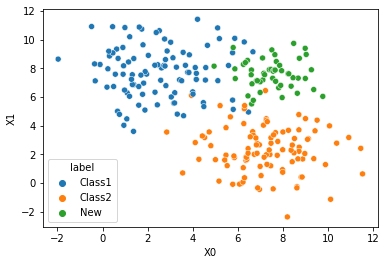

In [17]:
label_new = [2]*y_test.shape[0]

Xll =  np.vstack((X_train,X_test))
yll =  np.hstack((y_train,label_new))

y_as_label = [number_to_label[k] for k in yll]

data = pd.DataFrame({'X0': Xll[:,0], 'X1': Xll[:,1],'label': y_as_label})

data.head()
sns.scatterplot(data=data, x="X0", y="X1", hue="label");
plt.show()

In [19]:
performance_test = []
performance_train = []
k_range = list(range(1,16))  # <= for ploting later
for k in k_range:

    knn = KNeighborsClassifier(n_neighbors=k);
    knn.fit(X_train, y_train);
    
    y_pred = knn.predict(X_test)
    
    a = accuracy_score(y_test, y_pred)
    
    performance_test.append(a)
    
    y_pred = knn.predict(X_train)
    
    a = accuracy_score(y_train, y_pred)
    
    performance_train.append(a)

KNeighborsClassifier(n_neighbors=1)

KNeighborsClassifier(n_neighbors=2)

KNeighborsClassifier(n_neighbors=3)

KNeighborsClassifier(n_neighbors=4)

KNeighborsClassifier()

KNeighborsClassifier(n_neighbors=6)

KNeighborsClassifier(n_neighbors=7)

KNeighborsClassifier(n_neighbors=8)

KNeighborsClassifier(n_neighbors=9)

KNeighborsClassifier(n_neighbors=10)

KNeighborsClassifier(n_neighbors=11)

KNeighborsClassifier(n_neighbors=12)

KNeighborsClassifier(n_neighbors=13)

KNeighborsClassifier(n_neighbors=14)

KNeighborsClassifier(n_neighbors=15)

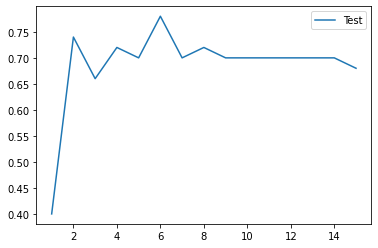

In [20]:
plt.plot(k_range, performance_test, label='Test');
plt.legend();
plt.show();

* Based on the graph, choosing $k>6$ will not increase the machine learning performance. Large values of k tends to be slow.


* The graph bellow we show the expect behavior while change $k$. The training performance reduce while the test performance will increase

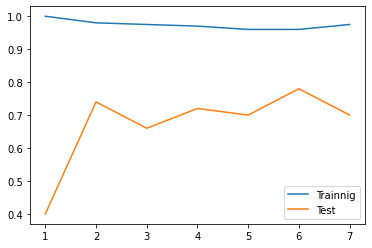

In [21]:
plt.plot(k_range[0:7], performance_train[0:7], label='Trainnig');
plt.plot(k_range[0:7], performance_test[0:7], label='Test');
plt.legend();
plt.show();

In [22]:
# Shameless stolen form: 
def plot_decision_boundaries(X, y, model_class, **model_params):
    """
    Function to plot the decision boundaries of a classification model.
    This uses just the first two columns of the data for fitting 
    the model as we need to find the predicted value for every point in 
    scatter plot.
    Arguments:
            X: Feature data as a NumPy-type array.
            y: Label data as a NumPy-type array.
            model_class: A Scikit-learn ML estimator class 
            e.g. GaussianNB (imported from sklearn.naive_bayes) or
            LogisticRegression (imported from sklearn.linear_model)
            **model_params: Model parameters to be passed on to the ML estimator
    
    Typical code example:
            plt.figure()
            plt.title("KNN decision boundary with neighbros: 5",fontsize=16)
            plot_decision_boundaries(X_train,y_train,KNeighborsClassifier,n_neighbors=5)
            plt.show()
    """
    try:
        X = np.array(X)
        y = np.array(y).flatten()
    except:
        print("Coercing input data to NumPy arrays failed")
    # Reduces to the first two columns of data
    reduced_data = X[:, :2]
    # Instantiate the model object
    model = model_class(**model_params)
    # Fits the model with the reduced data
    model.fit(reduced_data, y)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].    

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    # Meshgrid creation
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh using the model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predictions to obtain the classification results
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Plotting
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.xlabel("Feature-1",fontsize=15)
    plt.ylabel("Feature-2",fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    return plt

CPU times: user 16 s, sys: 115 ms, total: 16.1 s
Wall time: 16.5 s


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

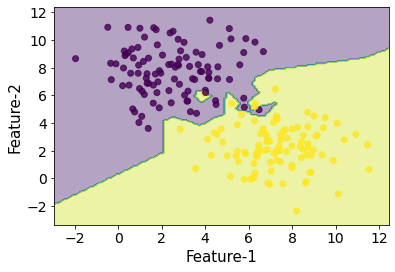

In [23]:
%%time
plot_decision_boundaries(X_train, y_train, KNeighborsClassifier,n_neighbors=1)

CPU times: user 18.6 s, sys: 284 ms, total: 18.8 s
Wall time: 19.8 s


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

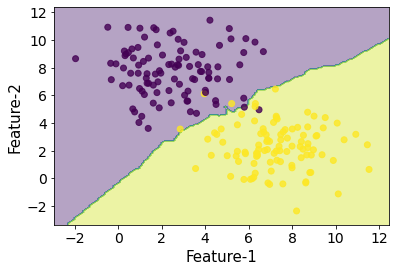

In [24]:
%%time
plot_decision_boundaries(X_train, y_train, KNeighborsClassifier,n_neighbors=10)